# Code for Section 6.5 Portfolio Rebalancing
This example shows you how to perform the Resampled Portfolio Rebalancing test based on the Euclidean norm and the combined marginal return and risk for mean-variance optimization.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import fortitudo.tech as ft
import matplotlib.pyplot as plt
from scipy.linalg import cholesky
from cvxopt import matrix
from cvxopt.solvers import socp
from copy import copy

In [2]:
# Load instrument info
instrument_names, means, covariance_matrix = ft.load_parameters()

In [3]:
I = len(instrument_names)
e_bm = np.ones((I, 1)) / I
e_0 = np.array([0, 0, 0, 0.1839, 0, 0, 0.0661, 0.25, 0.25, 0.25])  # Portfolio from Section 6.3.1

In [4]:
G = np.vstack((np.eye(I), -np.eye(I)))
G = np.hstack((G, np.zeros((G.shape[0], I))))  # Due to the benchmark relation
h = np.hstack((0.25 * np.ones(I), np.zeros(I)))
benchmark_relation = np.hstack((np.eye(I), -np.eye(I)))
A = matrix(np.vstack((np.hstack((np.ones(I), np.zeros(I))), benchmark_relation)))
b_ = matrix(np.vstack(([[1.]], e_bm)))

In [5]:
# Second order constraints
risk_target = 0.07
te_target = 0.02
scalar = 100
L = -cholesky(scalar**2 * covariance_matrix)
Gq_base = matrix(np.zeros((I + 1, 2 * I)))
Gq2 = [copy(Gq_base), copy(Gq_base)]
Gq2[0][1:, 0:I] = L
Gq2[1][1:, I:] = L
hq2 = [matrix(np.zeros((I + 1))), matrix(np.zeros((I + 1)))]
hq2[0][0] = risk_target * scalar
hq2[1][0] = te_target * scalar

In [6]:
# Extend the expected return vector and optimize
means2 = np.hstack((means, np.zeros(I)))
e_target = np.array(socp(
    c=matrix(-means2 * scalar), Gl=matrix(G), hl=matrix(h), Gq=Gq2, hq=hq2, A=A, b=b_)['x'][0:I])

In [7]:
# Verify optimization
print(np.sqrt(e_target.T @ covariance_matrix @ e_target))
print(np.sqrt((e_target - e_bm).T @ covariance_matrix @ (e_target- e_bm)))

[[0.07]]
[[0.02]]


In [8]:
# Parameter uncertainty specification
B = 1000  # Number of efficient frontiers
N = 100  # Sample size for parameter estimation
np.random.seed(0)  # To avoid numerical instability
return_sim = np.random.multivariate_normal(means, covariance_matrix, (N, B))

In [9]:
# Mean uncertainty
e_b = np.full((I, B), np.nan)
x_b = np.full((2 * I, B), np.nan)
for b in range(B):
    means_run = np.hstack((np.mean(return_sim[:, b, :], axis=0), np.zeros(I)))
    e_b[:, b] = np.array(socp(
        c=matrix(-scalar * means_run), Gl=matrix(G), hl=matrix(h), Gq=Gq2, hq=hq2, A=A, b=b_)['x'][0:I])[:, 0]
    x_b[0:I, b] = means * e_b[:, b]
    x_b[I:, b] = (covariance_matrix @ e_b[:, b]) / np.sqrt((e_b[:, b].T @ covariance_matrix @ e_b[:, b])) * e_b[:, b]
    

In [10]:
x_target = np.hstack((
    means * e_target[:, 0],
    (covariance_matrix @ e_target[:, 0]) / np.sqrt((e_target[:, 0].T @ covariance_matrix @ e_target[:, 0])) * e_target[:, 0]))
diff_target = np.linalg.norm(x_target[:, np.newaxis] - x_b, axis=0)
x_0 = np.hstack((
    means * e_0,
    (covariance_matrix @ e_0) / np.sqrt((e_0.T @ covariance_matrix @ e_0)) * e_0))
diff_0 = np.linalg.norm(x_target - x_0, axis=0)

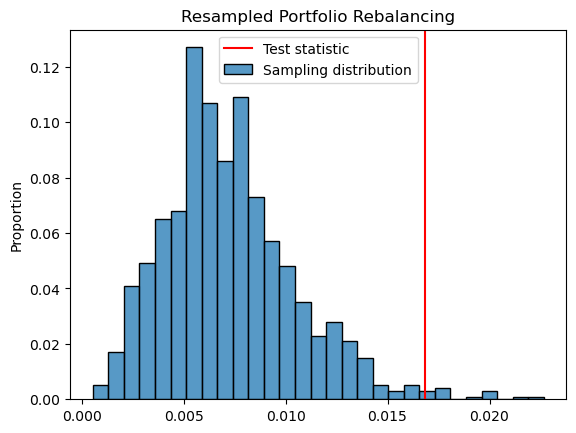

In [11]:
sns.histplot(diff_target, stat='proportion')
plt.axvline(diff_0, color='red')
plt.title('Resampled Portfolio Rebalancing')
plt.legend(['Test statistic', 'Sampling distribution'])
plt.show()

In [12]:
print(f'Rebalancing probability = {np.round(100 * np.sum((diff_target <= diff_0) / B), 2)}%')
print(f'Rebalancing p-value = {np.round(100 * np.sum((diff_target > diff_0) / B), 2)}%')

Rebalancing probability = 98.9%
Rebalancing p-value = 1.1%


In [13]:
df_results = pd.DataFrame(
    np.round(100 * np.hstack((e_target, e_0[:, np.newaxis], e_bm)), 2),
    index=instrument_names, columns=['Target', 'Current', 'Benchmark'])
df_results

,Target,Current,Benchmark
Gov & MBS,3.19,0.00,10.0
Corp IG,-0.00,0.00,10.0
Corp HY,0.52,0.00,10.0
EM Debt,25.00,18.39,10.0
DM Equity,3.25,0.00,10.0
EM Equity,-0.00,0.00,10.0
Private Equity,10.38,6.61,10.0
Infrastructure,16.01,25.00,10.0
Real Estate,16.66,25.00,10.0
Hedge Funds,25.00,25.00,10.0
